In [ ]:
cd /content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/

/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research


In [ ]:
!pwd

/content/drive/My Drive/TF2_OBJECT_DETECTION/models/research


In [ ]:
pip install .

Processing /content/drive/My Drive/TF2_OBJECT_DETECTION/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1370762 sha256=38810e1b2b0c843a58051b9c92ba7dba65aa3bc81eae9ca6ea84eceb971c2847
  Stored in directory: /tmp/pip-ephem-wheel-cache-rkweuvtr/wheels/f7/6c/3b/a0efa80908a22358abf0cbbdfe08e90bd0c9c51b508eca9259
Successfully built object-detection


In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import pathlib
from urllib.request import Request, urlopen

#Import the object detection modules
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile

In [ ]:
def  load_model(model_name):
	base_url =  'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
	model_file = model_name +  '.tar.gz'
	model_dir = tf.keras.utils.get_file(
	fname=model_name,
	origin=base_url + model_file,
	untar=True)
	model_dir = pathlib.Path(model_dir)/"saved_model"
	model = tf.saved_model.load(str(model_dir))
	return model

In [ ]:
def load_custom_model(model_name):
  model_file = model_name
  model_dir =  pathlib.Path(model_file)/"saved_model"
  model = tf.saved_model.load(str(model_dir))
  return model


In [ ]:
PATH_TO_LABELS =  '/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/training/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images')
TEST_IMAGE_PATHS =  sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.JPG")))
TEST_IMAGE_PATHS

[PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image10.JPG'),
 PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image11.JPG'),
 PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image12.JPG'),
 PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image13.JPG'),
 PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image14.JPG'),
 PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image15.JPG'),
 PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image16.JPG'),
 PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image17.JPG'),
 PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image18.JPG'),
 PosixPath('/content/drive/MyDrive/TF2_OBJECT_DETECTION/models/research/test_images/image19.JPG'),
 PosixPath

In [ ]:
model_name =  'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'
detection_model = load_model(model_name)

In [ ]:
model_name =  'exported-models/my_model'
detection_model = load_custom_model(model_name)


In [ ]:
print(detection_model.signatures['serving_default'].inputs)
detection_model.signatures['serving_default'].output_dtypes
detection_model.signatures['serving_default'].output_shapes

[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_0:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_1:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_2:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_3:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_4:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_5:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_6:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_7:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_8:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_9:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_10:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_11:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_12:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_13:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_14:0' shape=<unknown> dtype=resource>, <

{'detection_anchor_indices': TensorShape([1, 100]),
 'detection_boxes': TensorShape([1, 100, 4]),
 'detection_classes': TensorShape([1, 100]),
 'detection_multiclass_scores': TensorShape([1, 100, 91]),
 'detection_scores': TensorShape([1, 100]),
 'num_detections': TensorShape([1]),
 'raw_detection_boxes': TensorShape([1, 51150, 4]),
 'raw_detection_scores': TensorShape([1, 51150, 91])}

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

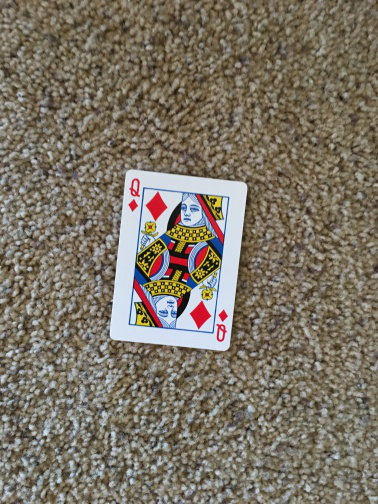

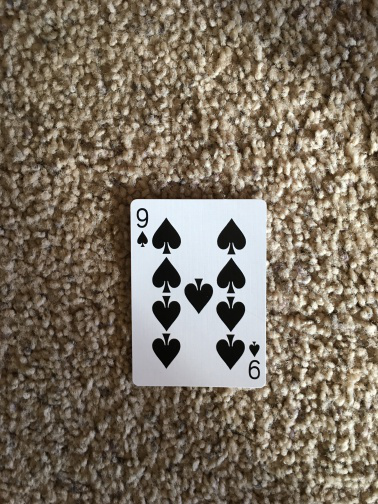

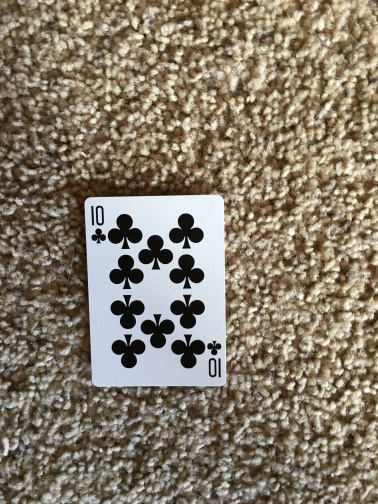

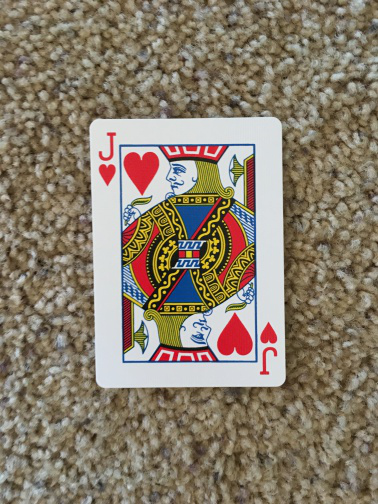

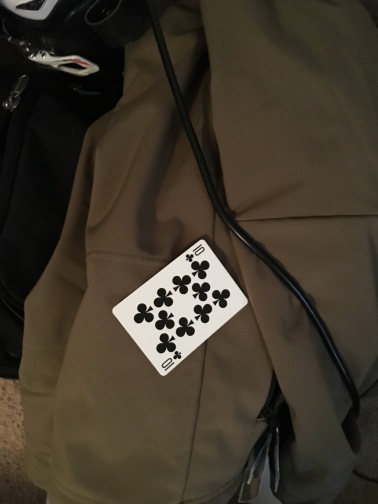

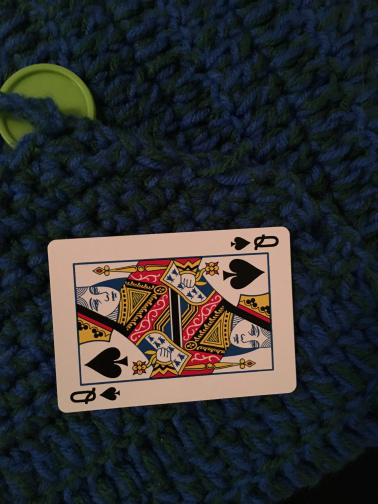

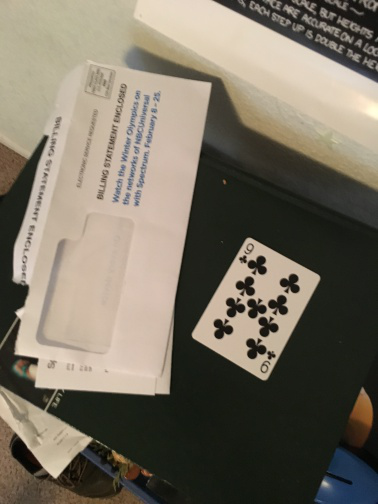

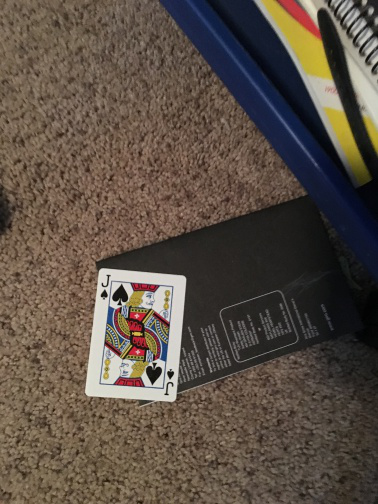

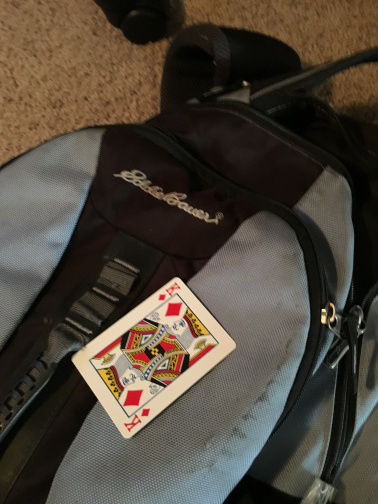

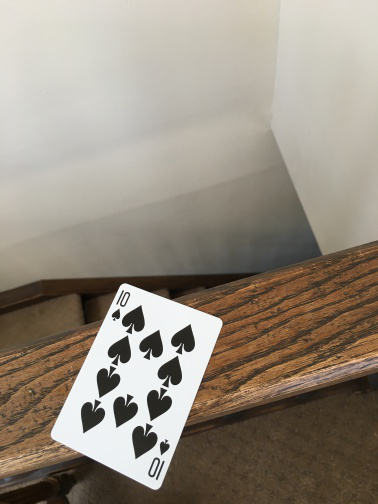

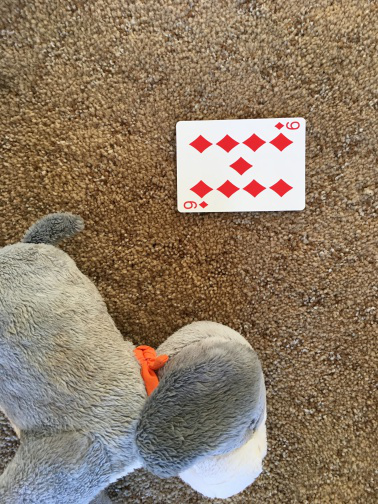

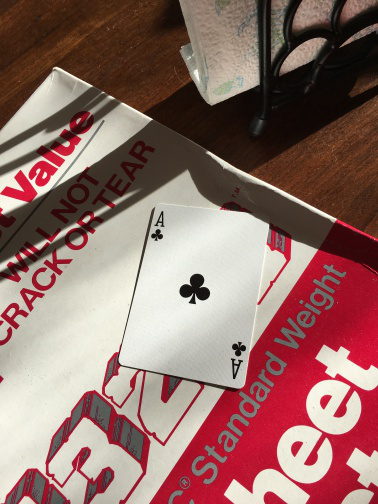

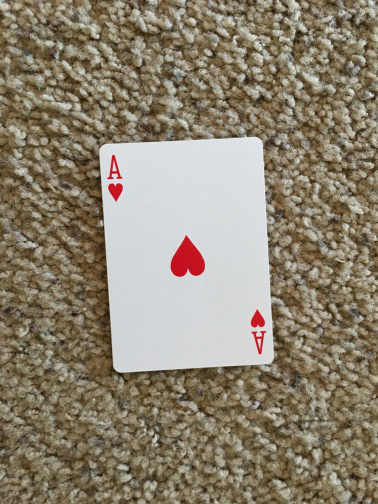

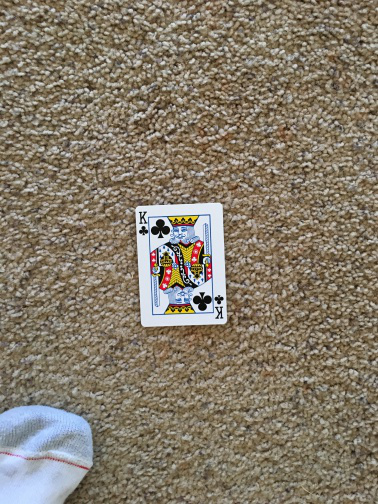

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

In [ ]:
pwd

'/content/drive/My Drive/TF2_OBJECT_DETECTION/models/research'

In [ ]:
!python model_main_tf2.py --model_dir=training --pipeline_config_path=training/pipeline.config

2020-12-14 15:27:48.465710: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-14 15:27:50.653819: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-14 15:27:50.658376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-14 15:27:50.658817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-12-14 15:27:50.658856: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-14 15:27:50.662039: I tensorflow/stream_executor/platform/default

In [ ]:
!!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path training/pipeline.config --trained_checkpoint_dir training/ --output_directory exported-models/my_model

['2020-12-14 15:37:26.349327: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1',
 '2020-12-14 15:37:28.382014: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1',
 '2020-12-14 15:37:28.386513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero',
 '2020-12-14 15:37:28.386960: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: ',
 'pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5',
 'coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s',
 '2020-12-14 15:37:28.387006: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1',
 '2020-12-14 15:37:28.389188: I tensorflow/st

In [ ]:
!python model_main_tf2.py --model_dir=training --pipeline_config_path=training/pipeline.config --checkpoint_dir=training

2020-12-12 13:54:28.145874: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
W1212 13:54:30.395178 139640603928448 model_lib_v2.py:1026] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I1212 13:54:30.395386 139640603928448 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1212 13:54:30.395488 139640603928448 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I1212 13:54:30.395567 139640603928448 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1212 13:54:30.395679 139640603928448 model_lib_v2.py:1041] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2020-12-12 13:54:30.405210: I tensorflow/stream_executor/